# FE 520 - Final Project

By
Naveen Nagarajan, Andy Dominiquez and Andrea Cherayath


## Introduction

This project explores market microstructure analytics and investment performance metrics using Python. Market microstructure analysis focuses on trading mechanisms, price discovery processes, and measures like bid-ask spreads, trade direction classification, and probability of informed trading (PIN). The investment performance metrics include key indicators like CAGR, ROI, Sharpe ratio and volatility measures that help evaluate investment strategy effectiveness. We analyze these concepts using Tesla (TSLA) high-frequency trading data and Apple (AAPL) historical price data to demonstrate practical applications.


## Market Microstructure Analysis Using finlib Package

This section demonstrates market microstructure analysis using the  finlib package, which implements several key measures and models:

- Trade Direction Classification
    Implementation of Lee-Ready algorithm for classifying trades as buys or sells based on trade price relative to quotes

- Information-Based Trading Measures
    Probability of Informed Trading (PIN) estimation using Easley, Kiefer, and O'Hara (EKOP) model to measure information asymmetry

- Volatility Analysis
    Roll's model for estimating effective spread and volatility from trade price series

- Liquidity Measures
    - Quoted spreads: Difference between best ask and bid prices
    - Effective spreads: Actual execution costs incorporating trade_direction

The analysis is performed on Tesla (TSLA) high-frequency trade and quote data from October 21, 2024.


In [1]:
import pandas as pd
import finlib.trade_direction as td
import finlib.pin_measure as pm
import finlib.volatility_measures as vm
import finlib.liquidity_measures as lm
import finlib.investment_metrics as im
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [9]:
import importlib
importlib.reload(lm)

<module 'finlib.liquidity_measures' from '/home/nnagarajan/workspace/Stevens FA/FE520 - Introduction to Python for Financial Apps/project/finlib/liquidity_measures.py'>

In [2]:
tsla_taq=pd.read_csv("data\tsla_taq_20241021_condensed.csv")
tsla_taq['Date.Time'] = pd.to_datetime(tsla_taq['Date.Time'])
tsla_taq.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
tsla_taq

,Date.Time,Ex.Cntrb.ID,Bid.Price,Bid.Size,Ask.Price,Ask.Size,Tick.Dir.,Price,Volume
0,2024-10-21 04:00:00.098902812-04:00,PSE,NaN,NaN,NaN,NaN,NaN,219.70,541.0
1,2024-10-21 04:00:00.116955090-04:00,DEX,219.66,1.0,219.70,2.0,NaN,221.00,6.0
2,2024-10-21 04:00:00.116955090-04:00,DEX,219.66,1.0,219.70,2.0,NaN,220.89,1.0
3,2024-10-21 04:00:00.116955090-04:00,DEX,219.66,1.0,219.70,2.0,NaN,220.89,10.0
4,2024-10-21 04:00:00.116955090-04:00,DEX,219.66,1.0,219.70,2.0,NaN,220.70,3.0
...,...,...,...,...,...,...,...,...,...
817711,2024-10-21 19:59:55.963028354-04:00,PSE,218.50,4.0,218.55,30.0,NaN,218.54,9.0
817712,2024-10-21 19:59:55.963570609-04:00,PSE,218.50,4.0,218.55,30.0,NaN,218.54,1.0
817713,2024-10-21 19:59:56.043247510-04:00,ADF,218.50,4.0,218.55,30.0,NaN,218.50,25.0
817714,2024-10-21 19:59:56.078043716-04:00,ADF,218.50,4.0,218.55,30.0,NaN,218.50,1.0


### The Bid-Ask Spread
The size of the bid/ask spread is an important object of study in microstructure theory, as a proxy for liquidity.

The bid-ask spread represents the difference between the highest price a buyer is willing to pay (bid) and the lowest price a seller is willing to accept (ask) for an asset. It is one of the most fundamental measures of market liquidity and transaction costs.

Key aspects of bid-ask spreads:

- **Market Liquidity**: Narrower spreads typically indicate higher liquidity and lower transaction costs
- **Market Maker Profits**: The spread compensates market makers for providing liquidity
- **Information Asymmetry**: Wider spreads may reflect greater information asymmetry between traders
- **Transaction Costs**: The spread represents an implicit cost for traders

Two common measures of spreads are:
1. Quoted Spread - The raw difference between best ask and bid prices
2. Effective Spread - The actual transaction costs incorporating trade direction


#### Quoted Spread
Quoted spread is defined in terms of quotes: best-ask $a_t$ and best-bid $b_t$ prices

$s^Q=\frac{1}{T}\sum_{t=1}^T (a_t-b_t)$

In [16]:
lm.quoted_spread(tsla_taq["Bid.Price"],tsla_taq["Ask.Price"])

-0.042639700433158845

#### Effective Spread
The efficient price $p_t^*$ is not observable and is usually proxied with mid-price $m_t=\frac{1}{2}(a_t+b_t)$

$ES=\frac{1}{T}\sum_{t=1}^T2q_t(p_t-m_t)$

In [17]:
lm.effective_spread(tsla_taq["Price"],tsla_taq["Bid.Price"],tsla_taq["Ask.Price"],trade_directions)

0.04251152849774049

### Trade Direction

Trade direction classification is essential for understanding order flow and market dynamics. We use two common methods:

1. **Lee-Ready Rule**
Based on trade price comparison with quotes:
- If trade price > midpoint: Buy (+1)
- If trade price < midpoint: Sell (-1) 
- If trade price = midpoint: Use tick test

2. **Tick Test**
Based on price changes:
- Uptick (price increase) or zero-uptick: Buy (+1)
- Downtick (price decrease) or zero-downtick: Sell (-1)

These methods help determine whether trades are buyer or seller initiated, which is crucial for:
- Calculating effective spreads
- Estimating order flow imbalance 
- Analyzing information-based trading


#### Lee-Ready rule
This test uses both trade prices pt and quotes $a_t$ , $b_t$ . The Lee-Ready rule decides if a trade is a buy or sell by comparing the trade price $p_t$ with the mid-price $m+t$ = $\frac{1}{2} (a_t +b_t )$ (the half-point between best-bid $b_t$ and best-ask $a_t$)

$$
d_t = \begin{cases}
+1 \text{ (buy)} & \text{if } p_t > m_t \\
-1 & \text{if } p_t < m_t \\
\text{tick rule} & \text{if } p_t = m_t
\end{cases}
$$


#### Tick test
This test uses on the trade prices $p_t$

$$
d_t =
\begin{cases}
+1 \text{ (buy)} & \text{if } p_t > p_{t-1} \text{ (uptick)} \text{ or if } p_t = p_{t-1} > p_{t-2} \text{ (zero-uptick)} \\
-1 \text{ (sell)} & \text{if } p_t < p_{t-1} \text{ (downtick)} \text{ or if } p_t = p_{t-1} < p_{t-2} \text{ (zero-downtick)}
\end{cases}
$$

In [ ]:
trade_directions=td.lee_ready_direction(tsla_taq["Price"],tsla_taq["Bid.Price"],tsla_taq["Ask.Price"])

In [5]:
tsla_taq["Direction"]=trade_directions

In [6]:
tsla_buy_vols=tsla_taq[tsla_taq["Direction"]==1]["Volume"]
tsla_sell_vols=tsla_taq[tsla_taq["Direction"]==-1]["Volume"]

### Probability of Informed Trading (PIN)

The Probability of Informed Trading (PIN) is a measure developed by Easley, Kiefer, O'Hara and Paperman (EKOP) to estimate the fraction of orders that come from informed traders. The model assumes:

- Trading days begin with nature determining if an information event occurs (probability α)
- Information can be good news (probability δ) or bad news (probability 1-δ)  
- Informed traders trade only on information event days (arrival rate μ)
- Uninformed buyers and sellers arrive at rate ε

The PIN is calculated as:


PIN = (α × μ) / (α × μ + 2ε)


Where:
- α = Probability
of
information
event
- μ = Arrival
rate
of
informed
traders
- ε = Arrival
rate
of
uninformed
traders

A
higher
PIN
indicates
greater
information
asymmetry in the
market, as a
larger
portion
of
trades
are
from informed traders.PIN is useful
for:
    - Measuring
adverse
selection
risk
- Analyzing
market
efficiency
- Studying
price
discovery
process


In [10]:
pm.pin_ekop(tsla_buy_vols, tsla_sell_vols)

np.float64(0.09090909090909091)

### Roll's Model
Roll's model (Roll, 1984) estimates the effective spread from the autocovariance of price changes. The model assumes that:
- True prices follow a random walk
- Observed prices deviate from true prices by half the spread
- Buy/sell orders are equally likely

The estimated spread is given by:

$s = 2\sqrt{-cov(\Delta p_t, \Delta p_{t-1})}$

where:
- $s$ is the estimated spread
- $\Delta p_t$ is the price change at time t
- $cov(\Delta p_t, \Delta p_{t-1})$ is the first-order autocovariance of price changes

The volatility estimate from Roll's model is:

$\sigma^2 = var(\Delta p_t) + cov(\Delta p_t, \Delta p_{t-1})$

where $\sigma^2$ is the variance of the true price changes.

The model reveals both the spread and volatility from just the price series, making it useful when quote data is unavailable.


In [65]:
vm.roll_model_analysis(tsla_taq["Price"].dropna())

{'Average Price': 218.31344714070912,
 'Daily Volatility (Roll)': 458.1250074867424,
 'Annualized Volatility (Roll)': 7272.509035137145,
 'Log-Normal Annualized Volatility (Roll)': 33.31223582599476,
 'Total Daily Volatility': 904.2754005279586,
 'Total Annualized Volatility': 14354.926959061826,
 'Log-Normal Total Annualized Volatility': 65.75374603383764}

## Investment Performance Metrics



#### Compound Annual Growth Rate (CAGR)
CAGR measures the annual growth rate of an investment over time, assuming returns are reinvested. It provides a "smoothed" rate of return.

$CAGR = \left(\frac{End Value}{Beginning Value}\right)^{\frac{1}{n}} - 1$

where n is the number of years.

#### Return on Investment (ROI)
ROI measures the profitability of an investment relative to its cost.

$ROI = \frac{End Value - Initial Value}{Initial Value}$

#### Sharpe Ratio
The Sharpe ratio measures the risk-adjusted return of an investment by comparing its excess return (return above risk-free rate) to its standard deviation (volatility).

$Sharpe\ Ratio = \frac{R_p - R_f}{\sigma_p}$

where:
- $R_p$ = Return of portfolio
- $R_f$ = Risk-free rate
- $\sigma_p$ = Standard deviation of portfolio returns

#### Volatility Measures
Volatility measures the dispersion of returns and is typically calculated as the standard deviation of returns:

$\sigma = \sqrt{\frac{1}{N-1}\sum_{i=1}^N(x_i-\mu)^2}$

where:
- $x_i$ = Return observation
- $\mu$ = Mean return
- $N$ = Number of observations

Additional volatility measures include:
- Historical Volatility: Standard deviation of past returns
- Implied Volatility: Market's forecast of likely price moves derived from options prices
- Realized Volatility: Actual observed volatility over a specific period


In [11]:
aapl_data = pd.read_csv("data\AAPL_Recent_May2023_May2024.csv", parse_dates=["Date"])
aapl_data.set_index("Date", inplace=True)
prices = aapl_data["Adj Close"]

         Metric     Value
0          CAGR -0.039481
1           ROI -0.039481
2  Sharpe Ratio -1.026047
3    Volatility  0.009896


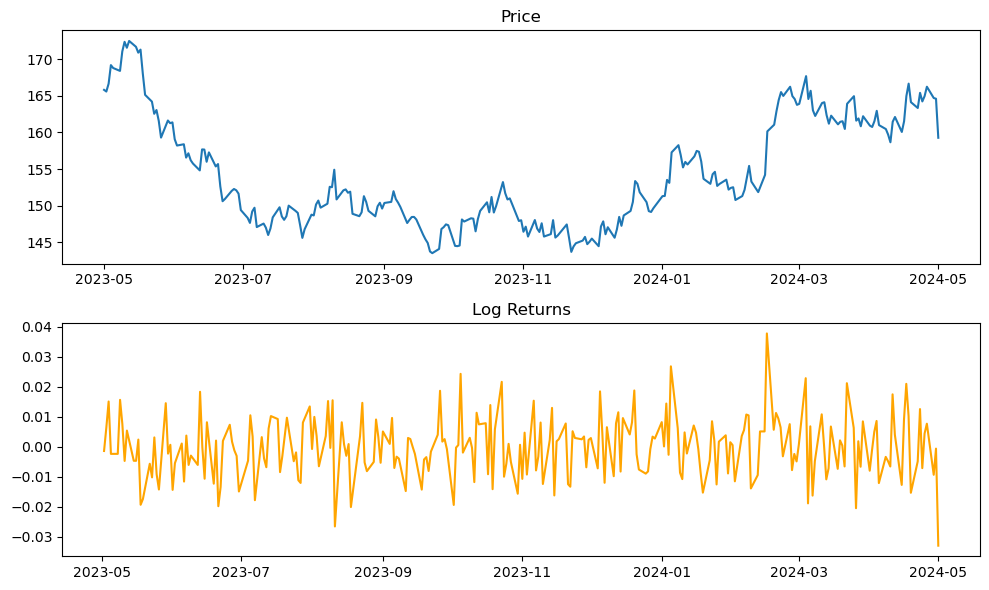

In [15]:
start_val = prices.iloc[0]
end_val = prices.iloc[-1]
returns = np.log(prices / prices.shift(1)).dropna()

# Calculate metrics
cagr_val = im.cagr(start_val, end_val, 1)
roi_val = im.roi(end_val, start_val)
sharpe_val = im.sharpe_ratio(returns)
volatility_val = im.calculate_volatility(prices)

# Display metrics
df_metrics = pd.DataFrame({
    "Metric": ["CAGR", "ROI", "Sharpe Ratio", "Volatility"],
    "Value": [cagr_val, roi_val, sharpe_val, volatility_val]
})
print(df_metrics)

# Plot
im.plot_price_and_returns(prices)